## 逻辑回归  
* 将问题构建为二元分类问题  
数据集的目标是 median_house_value，它是一个数值（连续值）特征。我们可以通过向此连续值使用阈值来创建一个布尔值标签。

我们希望通过某个城市街区的特征预测该街区的住房成本是否高昂。为了给训练数据和评估数据准备目标，我们针对房屋价值中位数定义了分类阈值 - 第 75 百分位数（约为 265000）。所有高于此阈值的房屋价值标记为 1，其他值标记为 0。

In [3]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2383,-117.5,33.7,6.0,454.0,102.0,213.0,43.0,11.0,483300.0
5330,-118.2,34.2,47.0,1717.0,314.0,868.0,295.0,3.6,160700.0
14792,-122.2,37.4,40.0,2223.0,412.0,1050.0,417.0,5.2,444500.0
1725,-117.2,33.4,17.0,1614.0,431.0,1031.0,389.0,2.1,134400.0
9275,-119.1,34.2,37.0,470.0,105.0,522.0,83.0,2.0,243800.0
...,...,...,...,...,...,...,...,...,...
2062,-117.3,34.0,18.0,1837.0,388.0,727.0,336.0,2.5,116700.0
12943,-121.8,37.4,31.0,5524.0,914.0,2848.0,879.0,5.6,229900.0
1612,-117.2,33.6,6.0,13724.0,2269.0,5860.0,1986.0,4.0,183000.0
3450,-117.9,33.8,34.0,2753.0,654.0,3117.0,631.0,3.2,170100.0


### 特征预处理 
在这里同之前不同，没有将median_house_value作为目标，而是创建一个新的二元目标median_house_value_is_high

In [7]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    #创建一个新的目标特征，即median_house_value_is_high
    #通过median_house_value是否大于265000来判断
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [8]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2627.9,537.8,1427.9,499.9,3.9,2.0
std,2.1,2.0,12.6,2152.7,421.4,1165.6,385.2,1.9,1.1
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1458.0,296.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2120.0,431.0,1165.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3129.2,647.0,1718.0,602.0,4.7,2.3
max,41.9,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2681.5,543.3,1433.6,504.4,3.9,2.0
std,2.1,2.0,12.6,2243.8,421.8,1104.1,383.0,2.0,1.3
min,32.5,-124.2,1.0,8.0,1.0,11.0,1.0,0.5,0.2
25%,33.9,-121.8,18.0,1471.8,299.8,791.8,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2153.5,441.0,1172.5,412.0,3.6,2.0
75%,37.7,-118.0,37.0,3204.8,654.0,1738.0,612.0,4.8,2.3
max,42.0,-114.3,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


### 训练一个线性回归模型进行比较
该模型将使用 {0, 1} 中的值为标签，并尝试预测一个尽可能接近 0 或 1 的连续值。此外，我们希望将输出解读为概率，所以最好模型的输出值可以位于 (0, 1) 范围内。然后我们会应用阈值 0.5，以确定标签。

In [10]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
                   for my_feature in input_features])

In [12]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [13]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods

  # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
  # Create input functions  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                training_targets["median_house_value_is_high"], 
                                batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                training_targets["median_house_value_is_high"], 
                                        num_epochs=1, 
                                        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                 validation_targets["median_house_value_is_high"], 
                                        num_epochs=1, 
                                        shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
    
    # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.49
  period 01 : 0.44
  period 02 : 0.47
  period 03 : 0.45
  period 04 : 0.43
  period 05 : 0.44
  period 06 : 0.47
  period 07 : 0.49
  period 08 : 0.45
  period 09 : 0.43
Model training finished.


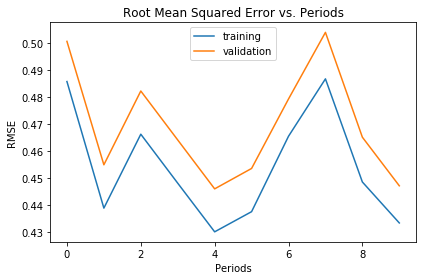

In [16]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.00001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 计算预测的对数损失函数  
检查预测，并确定是否可以使用它们来计算对数损失函数。

LinearRegressor 使用的是 L2 损失，在将输出解读为概率时，它并不能有效地惩罚误分类。例如，对于概率分别为 0.9 和 0.9999 的负分类样本是否被分类为正分类，二者之间的差异应该很大，但 L2 损失并不会明显区分这些情况。

相比之下，LogLoss（对数损失函数）对这些"置信错误"的惩罚力度更大。请注意，LogLoss 的定义如下：  
$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$  
但我们首先需要获得预测值。我们可以使用 LinearRegressor.predict 获得预测值。

array([-0.0163952 ,  0.13674815,  0.10816815, ...,  1.2215406 ,
       -0.2574041 ,  0.24691676], dtype=float32)

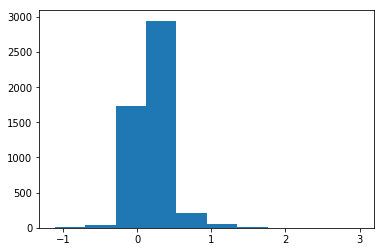

In [20]:
#使用LinearRegressor.predict来获得预测值
predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                   validation_targets["median_house_value_is_high"],
                                                   num_epochs=1,
                                                   shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)
validation_predictions

### 训练逻辑回归模型并计算验证集的对数损失函数  
要使用逻辑回归非常简单，用 LinearClassifier 替代 LinearRegressor 即可。  
**注意**：在 LinearClassifier 模型上运行 train() 和 predict() 时，您可以通过返回的字典（例如 predictions["probabilities"]）中的 "probabilities" 键获取实值预测概率。Sklearn 的 log_loss 函数可基于这些概率计算对数损失函数，非常方便。

In [23]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear classifier object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
  
  # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.59
  period 01 : 0.58
  period 02 : 0.56
  period 03 : 0.55
  period 04 : 0.58
  period 05 : 0.54
  period 06 : 0.53
  period 07 : 0.53
  period 08 : 0.53
  period 09 : 0.52
Model training finished.


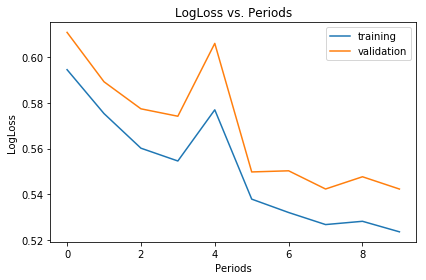

In [24]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 计算准确率并为验证集绘制ROC曲线   
LinearClassifier.evaluate 可计算准确率和 AUC 等实用指标。

In [25]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set:%0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set:0.72
Accuracy on the validation set: 0.74


可以使用类别概率（例如由 LinearClassifier.predict 和 Sklearn 的 roc_curve 计算的概率）来获得绘制 ROC 曲线所需的真正例率和假正例率。

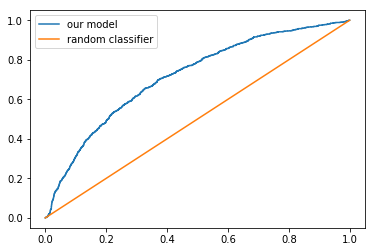

In [29]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)

validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0,1], [0,1], label="random classifier")
_=plt.legend(loc=2)

### 修改模型的学习设置来获得最佳的AUC

Training model...
LogLoss (on training data):
  period 00 : 0.50
  period 01 : 0.49
  period 02 : 0.48
  period 03 : 0.47
  period 04 : 0.47
  period 05 : 0.47
  period 06 : 0.47
  period 07 : 0.47
  period 08 : 0.47
  period 09 : 0.46
Model training finished.
AUC on the validation set: 0.80
Accuracy on the validation set: 0.78


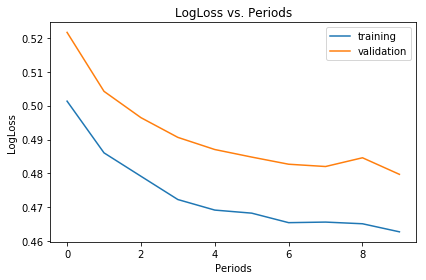

In [33]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000004,
    steps=10000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])